In [1]:
# define hyperparameter grid
learning_rates = [1e-4, 5e-5, 3e-5]
batch_sizes = [16] #[16, 32]
num_epochs = 4

# select the window size
window_size = 0

# Danae is doing:
#lr = [1e-4, 5e-5, 3e-5] + batch_size = [16] + num_epochs = 4 + window_size = 1

# define name of the file containing the fine-tuning results
output_filename = "tSBERT_finetuning_results_danae_1"

# Predicting german words using tsBERT (TongueSwitcher)

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import sys
import json
import random as rnd
from tqdm import tqdm
from operator import itemgetter

import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt


import torch
from torch.optim import AdamW
from torch.nn import CrossEntropyLoss
import torch.nn.functional as F
from torch.nn.functional import softmax
from torch.utils.data import Dataset, DataLoader

import transformers
from transformers import AutoTokenizer, AutoModelForTokenClassification

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

## Loading Data

In [4]:
# Local modules import
sys.path.append('..')

In [5]:
from data_loading import create_word_lists, tidy_sentence_length

In [6]:
with open('../data/corpus_data.json') as json_file:
    data = json.load(json_file)
records = data['records']

In [7]:
human_transcripts = [entry['human_transcript'] for entry in records]
stt_transcripts   = [entry['stt_transcript'] for entry in records]

In [8]:
# human-transcribed words, STT transcribed words, language labels, semantical errors, grammatical errors
human_words, stt_words, word_labels, word_grams, word_sems = \
    create_word_lists(records)

In [9]:
stt_transcripts, stt_words, labels, word_grams, word_sems = \
    tidy_sentence_length(stt_transcripts, stt_words, word_labels, word_grams, word_sems)

In [10]:
labels = [[1 if label else 0 for label in record_labels] for record_labels in labels]

## Quick Data Exploration

In [11]:
print(f"There are {len(records)} records in total.")

There are 6723 records in total.


In [12]:
nb_words_per_record = [len(record['words']) for record in records]

In [13]:
print(f"The minimum number of words in any transcript is {min(nb_words_per_record)}.")
print(f"The maximum number of words in any transcript is {max(nb_words_per_record)}.")
print(f"The median number of words across all transcripts is {int(np.median(nb_words_per_record))}.")

The minimum number of words in any transcript is 1.
The maximum number of words in any transcript is 517.
The median number of words across all transcripts is 6.


<Figure size 432x288 with 0 Axes>

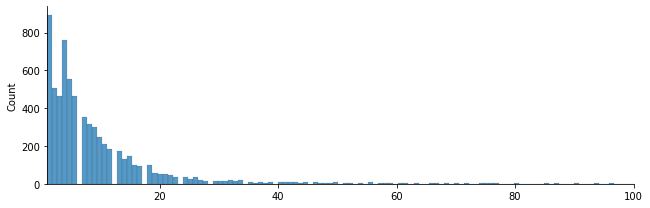

In [14]:
# plot the distribution of word counts
plt.figure(figsize=(6, 4))
sns.displot(nb_words_per_record, orientation='horizontal', height=3, aspect=3)
plt.xlim(1, 100)
plt.show()

In [15]:
def calculate_label_proportions(labels):
    total_tokens = sum(len(label_list) for label_list in labels)
    german_tokens = sum(label for label_list in labels for label in label_list)
    german_proportion = german_tokens / total_tokens
    return german_proportion, total_tokens

In [16]:
german_proportion, total_tokens = calculate_label_proportions(word_labels)
print(f"There are {total_tokens} words in total out of which only {german_proportion*100:.2f}% are german.")

There are 62305 words in total out of which only 3.00% are german.


## Data Preprocessing and Data Labelling

In [17]:
# load the tsBERT model and the tokenizer
model_name = "igorsterner/german-english-code-switching-identification"
model = AutoModelForTokenClassification.from_pretrained(model_name)
tokenizer = AutoTokenizer.from_pretrained(model_name)

### Incorporating Artificial Data

=> TO DO

### Transcripts Processing
--> how individual records are prepared for BERT

In [18]:
def create_contextual_input_with_labels(transcripts, labels, window_size=1, sep_token='[SEP]'):
    """
    Create contextual input with labels, setting labels of context to -100.

    Args:
        transcripts (list of list of str): List of tokenized transcripts.
        labels (list of list of int): List of labels for each transcript.
        window_size (int): Size of the context window.
        sep_token (str): Token used for separating sentences.

    Returns:
        tuple: Tuple containing modified transcripts and their corresponding labels.
    """
    if window_size == 0:
        return transcripts, labels

    contextual_transcripts = []
    contextual_labels = []

    for i, (transcript, label) in enumerate(zip(transcripts, labels)):
        # concatenate previous, current, and next transcripts within the window size
        start_idx = max(i - window_size, 0)
        end_idx = min(i + window_size + 1, len(transcripts))
        
        # prepare new transcript and labels
        new_transcript = []
        new_label = []

        for j in range(start_idx, end_idx):
            # intersperse the transcript with defined separator tokens ('.', [SEP], ...)
            new_transcript.extend(transcripts[j] + [sep_token])
            # extend labels with -100 for context transcripts, retain original for current
            new_label.extend([-100] * len(transcripts[j]) if j != i else labels[j])
            new_label.append(-100)  # for the SEP token

        new_transcript.pop()  # remove the last SEP token
        new_label.pop()       # remove the last label

        contextual_transcripts.append(new_transcript)
        contextual_labels.append(new_label)

    return contextual_transcripts, contextual_labels

In [19]:
def preprocess_labels(tokenized_inputs, input_labels):
    """
    Preprocess labels based on tsBERT tokenization.

    Args:
        tokenized_inputs (transformers.TokenizerOutput): Tokenized inputs.
        input_labels (list): Original labels for each input.

    Returns:
        list: Preprocessed labels for each tokenized input.
    """
    tsBERT_labels = []

    for i, _ in enumerate(tokenized_inputs.input_ids):
        # get the word indices from original inputs
        word_indices = tokenized_inputs.word_ids(batch_index=i)
        # get the labels of the current record
        record_labels = input_labels[i]
        # initialize a list to store the new labels for this record
        new_record_labels = []

        for word_idx in word_indices:
            # check if the word index is None => indicates a special token (e.g., [CLS], [SEP], [PAD])
            if word_idx is None:
                new_record_labels.append(-100)
            # otherwise, retrieve the label corresponding to this word index from the record labels
            else:
                new_record_labels.append(record_labels[word_idx])

        tsBERT_labels.append(new_record_labels)

    return tsBERT_labels

In [20]:
# select the window size
#window_size = 1

# compute the contextual input with labels
contextual_stt_input, contextual_labels = create_contextual_input_with_labels(stt_words, labels, window_size=window_size)

In [21]:
# set the desired total length for BERT embeddings (to make sure they are the same between train-validation-test sets)
max_length = 268  # set the desired total length

# tokenize the STT-transcribed transcripts using the BERT tokenizer
tokenized_inputs = tokenizer(contextual_stt_input, 
                             truncation=True, 
                             #padding=True,
                             padding="max_length", 
                             is_split_into_words=True,
                             max_length=max_length)

### Label Alignement
- we adjust the labels: since we add context (neighbour transcripts) and [SEP] tokens as input the the model, we also also need to adjust out labels to align with the new token structure.
- we assign an ignore index (-100) to these separator tokens since they don't carry meaningful language labels.

In [22]:
# align the labels so that they are suitable for the tsBERT model
tsBERT_labels = preprocess_labels(tokenized_inputs, contextual_labels)

### Homophone-Enriched Sentences

=> TO DO

## Train-Validation-Test Split

We need to extract which sentences contain German words in order to stratify the data split:

In [22]:
# !!!!!!!!!!!
#stt_transcripts = stt_transcripts[:500]
#contextual_stt_input = contextual_stt_input[:500]
#tsBERT_labels = tsBERT_labels[:500]

In [23]:
stat_labels = [[True if (label == 1) else False for label in record_labels] for record_labels in tsBERT_labels]
stat_labels = np.any(stat_labels, axis=1)

Here, we split only indices and not data itself:

In [24]:
indices = list(range(len(stt_transcripts)))
tr_indices, te_indices = train_test_split(indices, test_size=0.2, random_state=0, shuffle=True, stratify=stat_labels)

In [25]:
extract_train = itemgetter(*tr_indices)
extract_test  = itemgetter(*te_indices)

In [26]:
tr_contextual_stt_input = list(extract_train(contextual_stt_input))
tr_tsBERT_labels        = list(extract_train(tsBERT_labels))
# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
te_contextual_stt_input = list(extract_test(contextual_stt_input))
te_tsBERT_labels        = list(extract_test(tsBERT_labels))

## tsBERT Fine-tuning

In [27]:
class STTDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

In [28]:
# set the desired total length for BERT embeddings (to make sure they are the same between train-validation-test sets)
max_length = 268  # set the desired total length

train_inputs = tokenizer(tr_contextual_stt_input, 
                         truncation=True, 
                         #padding=True,
                         padding="max_length", 
                         is_split_into_words=True,
                         max_length=max_length)
#validation_inputs = tokenizer(val_contextual_stt_input, truncation=True, padding=True, is_split_into_words=True)
validation_inputs = tokenizer(te_contextual_stt_input, 
                              truncation=True, 
                              padding="max_length", 
                              is_split_into_words=True,
                              max_length=max_length)
test_inputs = tokenizer(te_contextual_stt_input, 
                        truncation=True, 
                        padding="max_length", 
                        is_split_into_words=True,
                        max_length=max_length)

#train_labels = preprocess_labels(train_inputs, train_labels)
#validation_labels = preprocess_labels(validation_inputs, val_labels)
#test_labels = preprocess_labels(test_inputs, test_labels)

train_labels = tr_tsBERT_labels
#validation_labels = val_tsBERT_labels
validation_labels = te_tsBERT_labels
test_labels = te_tsBERT_labels

In [29]:
# convert the tokenized input and label sets into a format suitable for training (datasets)
train_dataset = STTDataset(train_inputs, train_labels)
validation_dataset = STTDataset(validation_inputs, validation_labels)
test_dataset = STTDataset(test_inputs, test_labels)

### Hyperparameter Tuning

In [31]:
# define hyperparameter grid
recommended_learning_rates = [1e-4, 5e-5, 3e-5] # BERT authors recommend 3e-4, 1e-4, 5e-5, 3e-5
recommended_batch_sizes = [8, 16, 32] # BERT authors recommend 8, 16, 32, 64, 128
recommended_num_epochs = 5

In [30]:
def train_and_validate(model, train_loader, validation_loader, num_epochs, optimizer, loss_function, device):

    results = []
    
    print("Training")
    for epoch in range(num_epochs):
        
        print(f"Epoch {epoch+1}/{num_epochs}")
        
        # train/fine-tune the model
        model.train()
        total_train_loss = 0

        # Training loop
        for batch in tqdm(train_loader):
            
            # forward pass
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            
            # clear previous gradients
            optimizer.zero_grad()
            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)

            # compute loss and backpropagate
            loss = outputs.loss
            total_train_loss += loss.item()
            loss.backward()
            optimizer.step()

        avg_train_loss = total_train_loss / len(train_loader)

        print("Evaluating on validation set")
        
        # Validation loop
        validation_results = evaluate(model, validation_loader)
        validation_results['epoch'] = epoch
        validation_results['avg_train_loss'] = avg_train_loss

        print(f"Train Loss: {validation_results['avg_train_loss']}, Val Loss: {validation_results['avg_test_loss']}")
        
        results.append(validation_results)

    return results

In [31]:
def evaluate(model, test_loader):

    # evaluate the model
    model.eval()

    # initialize lists to store predictions and true labels
    true_labels = []
    predictions = []
    total_loss = 0

    # disable gradient calculation
    with torch.no_grad():
        for batch in test_loader:
            input_ids = batch['input_ids']
            attention_mask = batch['attention_mask']
            labels = batch['labels']

            # forward pass, get predictions
            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            total_loss += loss.item()

            logits = outputs.logits

            # apply softmax to convert logits to probabilities
            probabilities = F.softmax(logits, dim=-1)

            # iterate over each record in the batch
            for i in range(logits.shape[0]): # logits.shape[0] is the batch size
                # retrieve the probas
                record_probas = probabilities[i]
                record_predictions = []

                # keep track of the true labels corresponding to the predictions
                record_true_labels = labels[i][labels[i] != -100]  # exclude special tokens
                true_labels.append(record_true_labels.cpu().numpy())

                # iterate over each token
                for token_idx, label in enumerate(labels[i]):
                    if (label == -100):
                        continue
                    # get the most probable class and its score for this token
                    token_probas = record_probas[token_idx]
                    max_idx = torch.argmax(token_probas).item()
                    max_proba = token_probas[max_idx].item()

                    record_predictions.append([model.config.id2label[max_idx], max_proba])

                predictions.append(record_predictions)
    
    avg_loss = total_loss / len(test_loader)
    
    
    # flatten the predictions and convert them to binary format
    predicted_labels = [0 if pred[0] == 'E' else 1 for record_predictions in predictions for pred in record_predictions]
    flattened_true_labels = [label for record_labels in true_labels for label in record_labels]

    # ensure that true and predicted labels are correctly aligned
    if len(predicted_labels) != len(flattened_true_labels):
        raise ValueError("The length of predicted labels and true labels must be the same.")
        
    # compute evaluation metrics
    accuracy = accuracy_score(flattened_true_labels, predicted_labels)
    precision, recall, f1, _ = precision_recall_fscore_support(flattened_true_labels, predicted_labels, average='binary')


    return {'avg_test_loss': avg_loss, 'accuracy': accuracy, 'precision': precision, 'recall': recall, 'f1': f1}

In [ ]:
# storage for all model results
all_results = []

# hyperparameter Tuning Loop
for lr in learning_rates:
    for batch_size in batch_sizes:
        # initialize model, optimizer, and loss function for each combination
        model = AutoModelForTokenClassification.from_pretrained(model_name)
        optimizer = AdamW(model.parameters(), lr=lr)
        loss_function = CrossEntropyLoss(ignore_index=-100)
        
        # GPU Acceleration
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        model = model.to(device)

        # prepare the DataLoaders
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        validation_loader = DataLoader(validation_dataset, batch_size=batch_size)
        test_loader = DataLoader(test_dataset, batch_size=batch_size)

        # train and validate the model
        results = train_and_validate(model, train_loader, validation_loader, num_epochs, optimizer, loss_function, device)
        
        # store results
        all_results.append([lr, batch_size, results])

Training
Epoch 1/4
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


  0%|▏                                          | 1/340 [00:05<33:13,  5.88s/it]

In [ ]:
# convert the list of results to a pandas DataFrame
all_results_df = pd.DataFrame.from_records([{
    'learning_rate': lr,
    'batch_size': bs,
    'epoch': r['epoch'],
    'train_loss': r['avg_train_loss'],
    'val_loss': r['avg_test_loss'],
    'val_accuracy': r['accuracy'],
    'val_precision': r['precision'],
    'val_recall': r['recall'],
    'val_f1': r['f1']
} for lr, bs, result_list in all_results for r in result_list])

# save to CSV
all_results_df.to_csv('../data/' + output_filename + '.csv', index=False)

In [ ]:
#model.save_pretrained("./finetuned_tsbert_lr_" + str(lr) + "batch_size_" + str(batch_size))
#tokenizer.save_pretrained("./finetuned_tsbert_lr_" + str(lr) + "batch_size_" + str(batch_size))